<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Import packages</h1>

In [ ]:
import easydict
import os
import numpy as np
import math
import matplotlib.pyplot as plt
 
import torchvision.transforms as transforms
from torchvision.utils import save_image
 
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
 
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
 
import pandas as pd
from tqdm import tqdm 
import time
 
from random import randint
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML
from matplotlib import rc
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

from scipy.interpolate import interp1d

%matplotlib inline
 
import copy as cp
from IPython.display import clear_output
 
os.makedirs("images", exist_ok=True)
arg = easydict.EasyDict({ "n_epochs": 15000, 
                          "batch_size": 256, 
                          "lr": 1e-3, 
                          "b1": 0.9,
                          "b2": 0.999,
                          "weight_decay": 0.0001,
                          "input_dim": 40,
                          "output_dim": 40,
                          "hidden_dim": [128,40],
                          "goal_dim": 6,
                          "n_cpu": 8,
                          "re_size": 64,
                          "z_dim": 128,
                          "sample_interval": 400 })
print(arg)
 
dt=2
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

use_cuda = True
if torch.cuda.is_available():
  device = torch.device("cuda")

  

{'n_epochs': 15000, 'batch_size': 256, 'lr': 0.001, 'b1': 0.9, 'b2': 0.999, 'weight_decay': 0.0001, 'input_dim': 40, 'output_dim': 40, 'hidden_dim': [128, 40], 'goal_dim': 6, 'n_cpu': 8, 're_size': 64, 'z_dim': 128, 'sample_interval': 400}


<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

#<h1>Data organization</h1>

In [ ]:
# Load data
TESTterrain = torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain_XYZ_tensor.npy'))#[:-6000]
TESTterrain[-5999:] = 0.4 + TESTterrain[-5999:] 

# Place Path data into dataloader
class GenDataset(Dataset):
 
  def __init__(self, TerrainData, transform=None):
      self.data = TerrainData.float()
      self.transform = transform
      
  def __getitem__(self, index):
      data = self.data[index]
      if self.transform:
            data = self.transform(data)
      return index, data
 
  def __len__(self):
      return len(self.data)
 
transform = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.Resize((arg.re_size, arg.re_size)),
     transforms.ToTensor(),
    ])
 
DeepQMPdataset = GenDataset(TESTterrain, transform=transform)
DeepQMPdata_loader = DataLoader(DeepQMPdataset,batch_size=arg.batch_size,shuffle=False)

def show(img,nrow=3):
  img_grid = torchvision.utils.make_grid(img,nrow=nrow).numpy()
  plt.figure()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('on')
  plt.show()

_, img = next(iter(DeepQMPdata_loader))
show(img[-9:,2].view(-1,1,100,100),nrow=3)

# np.save('/content/drive/MyDrive/Colab Notebooks/data/Terrain64x64', img)

# del TESTterrain

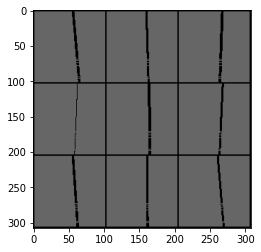

In [ ]:
tdata_loader = DataLoader(DeepQMPdataset,batch_size=len(DeepQMPdataset),shuffle=False)

_, img = next(iter(tdata_loader))
show(img[-9:,2].view(-1,1,64,64),nrow=3)

tensor(0.)
tensor(0.4000)


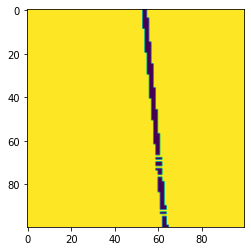

In [ ]:
test=TESTterrain[-5999:,2]
print(test.min())
print(test.max())
plt.imshow(test[0].view(arg.re_size,arg.re_size))

In [ ]:
class TeerainEncoder(nn.Module):
  def __init__(self): 
        super(TeerainEncoder, self).__init__()
        latent_dim = arg.z_dim
        self.latent_dim = latent_dim
        self.im_channels = in_channels = 1

        modules = []
        hidden_dims = [32, 64, 64, 128, 256]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.res_dim = 4
        self.encoder = nn.Sequential(*modules)
        self.LatentSpace = nn.Linear(hidden_dims[-1]*(self.res_dim**2), latent_dim)

        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*(self.res_dim**2))
        hidden_dims.reverse()
        for i in range(len(hidden_dims) - 2):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3, stride = 2, padding=1, output_padding=0),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                                          nn.ConvTranspose2d(hidden_dims[-2],
                                                              hidden_dims[-1],
                                                              kernel_size=3,
                                                              stride=2,
                                                              padding=1,
                                                              output_padding=1),
                                          nn.BatchNorm2d(hidden_dims[-1]),
                                          nn.LeakyReLU(),
                                          nn.ConvTranspose2d(hidden_dims[-1],
                                                              hidden_dims[-1],
                                                              kernel_size=3,
                                                              stride=2,
                                                              padding=1,
                                                              output_padding=1),
                                          nn.BatchNorm2d(hidden_dims[-1]),
                                          nn.LeakyReLU(),
                                          nn.Conv2d(hidden_dims[-1], out_channels= self.im_channels,
                                                    kernel_size= 3, padding= 1),
                                          nn.Tanh())

  def encode(self, input: Tensor):
      result = self.encoder(input)
      result = torch.flatten(result, start_dim=1)
      latent = self.LatentSpace(result)

      return latent

  def decode(self, z: Tensor):
      result = self.decoder_input(z)
      result = result.view(-1, self.hidden_dims[-1], self.res_dim, self.res_dim)
      result = self.decoder(result)
      result = self.final_layer(result)

      return result

  # def forward(self, input: Tensor, **kwargs):
  #     z = self.encode(input)
  #     recon = self.decode(z)
  #     return  [recon, input, z]

  def forward(self, z_in, input: Tensor, **kwargs):
      z = self.encode(input)
      recon = self.decode(z_in)
      return  [recon, input, z]

  def loss_function(self,
                    *args,
                    **kwargs):
      recons = args[0]
      input = args[1]
      recons_loss =F.mse_loss(recons, input)

      return {'loss': recons_loss}
      
# Network model
Terrain_Info = TeerainEncoder()
if cuda:
    Terrain_Info.cuda()

print("Load encoder.")
Terrainparams = torch.load("/content/drive/MyDrive/Colab Notebooks/model/TerrainEncoder.tar", map_location = "cpu")
Terrain_Info.load_state_dict(Terrainparams['model_state_dict'])
Terrain_Info.eval()

In [ ]:
# print("Resize img..")
# img = torch.tensor(np.load('/content/drive/MyDrive/Colab Notebooks/data/Terrain64x64.npy'))

DeepQMPdata_loader = DataLoader(DeepQMPdataset,batch_size=arg.batch_size,shuffle=False)

print("Go through encoder...")
for batch_idx, TerrainData in tqdm(enumerate(DeepQMPdata_loader), position=0, leave=True):
  newLatent = Terrain_Info(TerrainData[1][:,2].view(-1,1,arg.re_size,arg.re_size).type(Tensor))[-1].detach()
  if batch_idx==0:
    latentSpace=newLatent.type(Tensor)
  else:
    latentSpace=torch.cat([latentSpace,newLatent.type(Tensor)],dim=0)
  # del TerrainData, newLatent
  torch.cuda.empty_cache()
np.save('/content/drive/MyDrive/Colab Notebooks/data/TerrainLatent',latentSpace.cpu().detach())
print("LatentSpacesaved!!!")

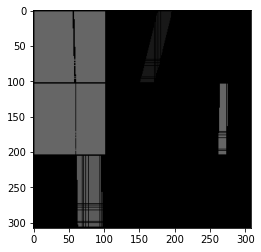

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


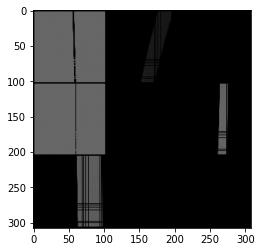

In [ ]:
DeepQMPdata_loader = DataLoader(DeepQMPdataset,batch_size=arg.batch_size,shuffle=True)
_, img = next(iter(DeepQMPdata_loader))
out_,in_,lat = Terrain_Info(img[:,2].view(-1,1,arg.re_size,arg.re_size).type(Tensor))
show(in_[-9:].cpu().view(-1,1,arg.re_size,arg.re_size),nrow=3)
show(out_[-9:].cpu().view(-1,1,arg.re_size,arg.re_size),nrow=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


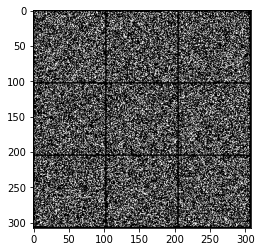

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


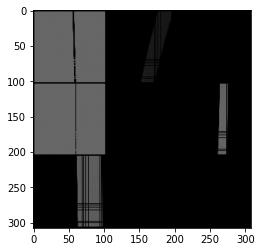

In [ ]:
out_,in_,lat = Terrain_Info(lat,torch.randn((256,1,arg.re_size,arg.re_size)).type(Tensor))

show(in_[-9:].cpu().view(-1,1,arg.re_size,arg.re_size),nrow=3)
show(out_[-9:].cpu().view(-1,1,arg.re_size,arg.re_size),nrow=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


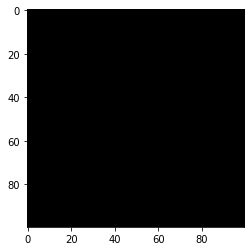

In [ ]:
PATH='/content/drive/MyDrive/Colab Notebooks'

# Load data
mylat = torch.tensor(np.load(PATH+'/data/TerrainLatent.npy'))
index = randint(0, mylat.shape[0])
out_,in_,lat = Terrain_Info(mylat[index].type(Tensor),torch.randn((256,1,100,100)).type(Tensor))
show(out_[-9:].cpu().view(-1,1,100,100),nrow=3)